In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os

# Eurovision Song Contest (ESC) Analysis

## Data Familiarization

In [11]:
# Get current directory
cwd = os.getcwd()
print(cwd)

c:\Users\mate1\OneDrive\Escritorio\Repository\Eurovision_Contest_Analysis


In [12]:
# Load data
df_votes = pd.read_csv('Data/votes.csv')
df_votes

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,at,nl,6,NaN,NaN
1,1957,final,at,fr,at,fr,0,NaN,NaN
2,1957,final,at,dk,at,dk,0,NaN,NaN
3,1957,final,at,lu,at,lu,3,NaN,NaN
4,1957,final,at,de,at,de,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
51349,2023,final,wld,al,wld,al,6,6.0,NaN
51350,2023,final,wld,pt,wld,pt,0,0.0,NaN
51351,2023,final,wld,rs,wld,rs,0,0.0,NaN
51352,2023,final,wld,gb,wld,gb,0,0.0,NaN


In [13]:
# Get the initial and last years of the data
initial_year = df_votes['year'].min()
final_year = df_votes['year'].max()
print('Initial year:', initial_year)
print('Final year:', final_year)

Initial year: 1957
Final year: 2023


### Data Cleaning

In this work we are only interested in the final round.

In [14]:
# Get only the final round
df_final_round = df_votes[df_votes['round'] == 'final']

In [15]:
# Remove giving 0 points
df_final_round = df_final_round[df_final_round['total_points'] > 0]

In [16]:
# Get the total number of countries
total_countries = df_final_round['from_country_id']
total_countries = np.array(total_countries)
total_countries = np.unique(total_countries)
print('Total countries:', total_countries)
print('Number of countries:', len(total_countries))

Total countries: ['ad' 'al' 'am' 'at' 'au' 'az' 'ba' 'be' 'bg' 'by' 'ch' 'cs' 'cy' 'cz'
 'de' 'dk' 'ee' 'es' 'fi' 'fr' 'gb' 'ge' 'gr' 'hr' 'hu' 'ie' 'il' 'is'
 'it' 'lt' 'lu' 'lv' 'ma' 'mc' 'md' 'me' 'mk' 'mt' 'nl' 'no' 'pl' 'pt'
 'ro' 'rs' 'ru' 'se' 'si' 'sk' 'sm' 'tr' 'ua' 'wld' 'yu']
Number of countries: 53


In [17]:
# Broadcast the Yugoslavia points to their actual countries
broadcast = {
    'yu': ['ba', 'hr', 'mk', 'rs', 'si'],
    'cs': ['rs', 'me']
}

df_final_round['from_country_id'] = df_final_round['from_country_id'].apply(lambda x: broadcast[x] if x in broadcast.keys() else x)
df_final_round['to_country_id'] = df_final_round['to_country_id'].apply(lambda x: broadcast[x] if x in broadcast.keys() else x)
df_final_round.explode('from_country_id').explode('to_country_id')

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,at,nl,6,NaN,NaN
3,1957,final,at,lu,at,lu,3,NaN,NaN
6,1957,final,at,gb,at,gb,1,NaN,NaN
10,1957,final,be,nl,be,nl,5,NaN,NaN
11,1957,final,be,fr,be,fr,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...
51340,2023,final,wld,hr,wld,hr,3,3.0,NaN
51341,2023,final,wld,am,wld,am,8,8.0,NaN
51343,2023,final,wld,fr,wld,fr,1,1.0,NaN
51344,2023,final,wld,es,wld,es,2,2.0,NaN


In [188]:
# Dictionary with the real name of the countries
country_id_to_name = {
    'ad': 'Andorra',
    'al': 'Albania',
    'am': 'Armenia',
    'at': 'Austria',
    'au': 'Australia',
    'az': 'Azerbaijan',
    'ba': 'Bosnia and Herzegovina',
    'be': 'Belgium',
    'bg': 'Bulgaria',
    'by': 'Belarus',
    'ch': 'Switzerland',
    'cs': 'Serbia and Montenegro',  # Historical ID
    'cy': 'Cyprus',
    'cz': 'Czech Republic',
    'de': 'Germany',
    'dk': 'Denmark',
    'ee': 'Estonia',
    'es': 'Spain',
    'fi': 'Finland',
    'fr': 'France',
    'gb': 'United Kingdom',
    'ge': 'Georgia',
    'gr': 'Greece',
    'hr': 'Croatia',
    'hu': 'Hungary',
    'ie': 'Ireland',
    'il': 'Israel',
    'is': 'Iceland',
    'it': 'Italy',
    'lt': 'Lithuania',
    'lu': 'Luxembourg',
    'lv': 'Latvia',
    'ma': 'Morocco',
    'mc': 'Monaco',
    'md': 'Moldova',
    'me': 'Montenegro',
    'mk': 'North Macedonia',
    'mt': 'Malta',
    'nl': 'Netherlands',
    'no': 'Norway',
    'pl': 'Poland',
    'pt': 'Portugal',
    'ro': 'Romania',
    'rs': 'Serbia',
    'ru': 'Russia',
    'se': 'Sweden',
    'si': 'Slovenia',
    'sk': 'Slovakia',
    'sm': 'San Marino',
    'tr': 'Turkey',
    'ua': 'Ukraine',
    'wld': 'World',  # Possible placeholder for aggregated data
    'yu': 'Yugoslavia'  # Historical ID
}

In [189]:
df_final_round['from_country'] = df_final_round['from_country'].map(country_id_to_name)
df_final_round['to_country'] = df_final_round['to_country'].map(country_id_to_name)

In [190]:
df_final_round

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,Austria,Netherlands,6,NaN,NaN
3,1957,final,at,lu,Austria,Luxembourg,3,NaN,NaN
6,1957,final,at,gb,Austria,United Kingdom,1,NaN,NaN
10,1957,final,be,nl,Belgium,Netherlands,5,NaN,NaN
11,1957,final,be,fr,Belgium,France,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...
51340,2023,final,wld,hr,World,Croatia,3,3.0,NaN
51341,2023,final,wld,am,World,Armenia,8,8.0,NaN
51343,2023,final,wld,fr,World,France,1,1.0,NaN
51344,2023,final,wld,es,World,Spain,2,2.0,NaN


In [191]:
# Get the number of participations of each country

# Combine all country IDs into a single column with the corresponding year
participations = pd.concat([
    df_final_round[['year', 'from_country']].rename(columns={'from_country': 'country'}),
    df_final_round[['year', 'to_country']].rename(columns={'to_country': 'country'})
])

# Explode the lists into individual rows
participations = participations.explode('country')

# Drop duplicates to ensure each country-year combination is only counted once
participations = participations.drop_duplicates()

# Count the number of unique years each country participated
participation_counts = participations.groupby('country')['year'].nunique()

# Convert the result to a DataFrame (optional)
participation_counts = participation_counts.reset_index()
participation_counts.columns = ['country', 'participation_count']

# Change the country IDs to their full names
# participation_counts['country_name'] = participation_counts['country_id'].map(country_id_to_name)

# Represent in a table the number of participations of each country with their complete name
participation_counts = participation_counts.sort_values('participation_count', ascending=False)
participation_counts[['country', 'participation_count']]


,country,participation_count
18,Germany,65
50,United Kingdom,65
16,France,64
7,Belgium,63
33,Netherlands,62
45,Spain,62
46,Sweden,62
47,Switzerland,62
35,Norway,61
15,Finland,56


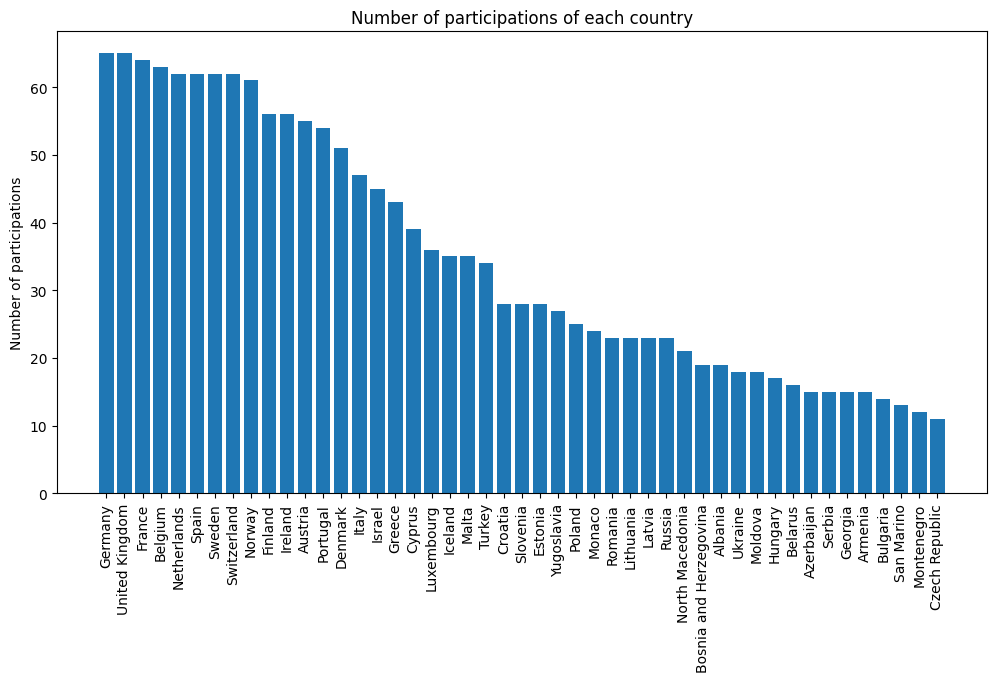

In [192]:
# Delete the countries with less than 10 participations
participation_counts = participation_counts[participation_counts['participation_count'] >= 10]

plt.figure(figsize=(12, 6))
plt.bar(participation_counts['country'], participation_counts['participation_count'])
plt.xticks(rotation=90)
plt.ylabel('Number of participations')
plt.title('Number of participations of each country')
plt.show()

In [193]:
# Update teh dataframe
df_final_round = df_final_round[df_final_round['from_country'].isin(participation_counts['country'])]
df_final_round = df_final_round[df_final_round['to_country'].isin(participation_counts['country'])]
df_final_round

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,Austria,Netherlands,6,NaN,NaN
3,1957,final,at,lu,Austria,Luxembourg,3,NaN,NaN
6,1957,final,at,gb,Austria,United Kingdom,1,NaN,NaN
10,1957,final,be,nl,Belgium,Netherlands,5,NaN,NaN
11,1957,final,be,fr,Belgium,France,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...
51315,2023,final,gb,am,United Kingdom,Armenia,3,0.0,3.0
51318,2023,final,gb,es,United Kingdom,Spain,5,0.0,5.0
51319,2023,final,gb,md,United Kingdom,Moldova,1,1.0,0.0
51320,2023,final,gb,pl,United Kingdom,Poland,8,8.0,0.0


In [194]:
# Get the total number of countries
total_countries = df_final_round['from_country']
total_countries = np.array(total_countries)
total_countries = np.unique(total_countries)
print('Total countries:', total_countries)
print('Number of countries:', len(total_countries))

Total countries: ['Albania' 'Armenia' 'Austria' 'Azerbaijan' 'Belarus' 'Belgium'
 'Bosnia and Herzegovina' 'Bulgaria' 'Croatia' 'Cyprus' 'Czech Republic'
 'Denmark' 'Estonia' 'Finland' 'France' 'Georgia' 'Germany' 'Greece'
 'Hungary' 'Iceland' 'Ireland' 'Israel' 'Italy' 'Latvia' 'Lithuania'
 'Luxembourg' 'Malta' 'Moldova' 'Monaco' 'Montenegro' 'Netherlands'
 'North Macedonia' 'Norway' 'Poland' 'Portugal' 'Romania' 'Russia'
 'San Marino' 'Serbia' 'Slovenia' 'Spain' 'Sweden' 'Switzerland' 'Turkey'
 'Ukraine' 'United Kingdom' 'Yugoslavia']
Number of countries: 47


### Country analyzer

#### Number of wins

In [195]:
# Get the number of wins of each country
country_wins = np.zeros(len(total_countries))
countries = np.array(participation_counts['country'])
for year in range(initial_year, final_year + 1):
    country_winner = 0
    for i,country_id in enumerate(countries): 
        country_points = df_final_round[(df_final_round['year'] == year) & (df_final_round['to_country'] == country_id)]['total_points'].sum()
        if country_points> country_winner:
            country_winner = country_points
            winner = i
    country_wins[winner] += 1

print('The country with the most wins is:', total_countries[np.argmax(country_wins)], 'with a total of:', np.max(country_wins))
print('The country with the least wins is:', total_countries[np.argmin(country_wins)], 'with a total of:', np.min(country_wins))        

The country with the most wins is: Czech Republic with a total of: 7.0
The country with the least wins is: Greece with a total of: 0.0


np.float64(67.0)

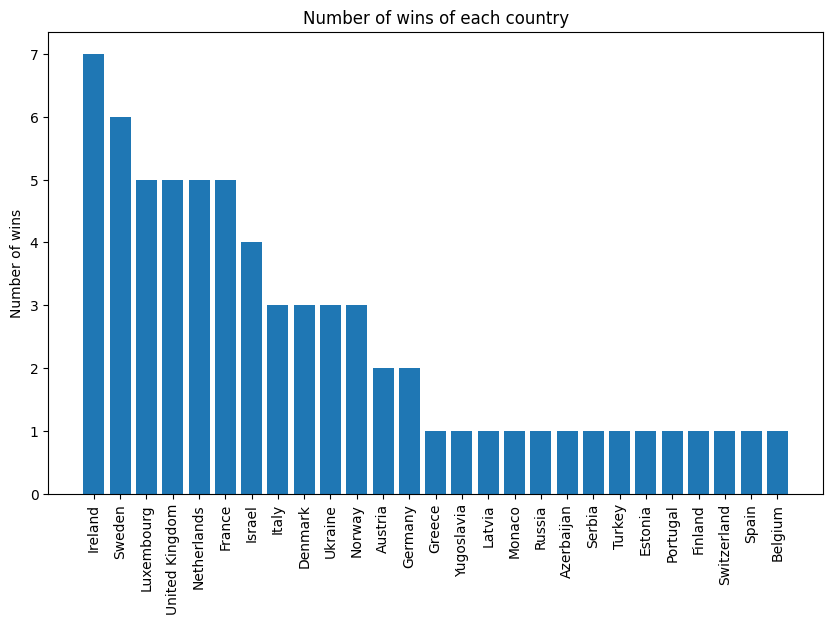

In [199]:

cw = country_wins[country_wins > 0]
x = np.array(participation_counts['country'])[country_wins > 0]

idx_sort = cw.argsort()
cw = cw[idx_sort[::-1]]
x = x[idx_sort[::-1]]

plt.figure(figsize=(10, 6))
plt.bar(x, cw)
plt.xticks(rotation=90)
plt.ylabel('Number of wins')
plt.title('Number of wins of each country')
plt.show()

#### One country analyzer

Number of points given by Spain before 1997 and after 1997 + Boxplot of normalized points

In [176]:
# Function to obtain the number of points given for a given country during a time period

def family_points(df_final_round, country_id, initial_year, final_year, crop=15):
    
    # Get the number of points given by country_id to each country
    friends = df_final_round.query(f'year >= {initial_year} and from_country=="{country_id}"')

    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,8))

    friends.pivot_table(index='to_country',values='jury_points',aggfunc='sum').fillna(0).sort_values('jury_points', ascending=False).head(crop).plot(kind='bar',stacked=True,ax=axs[0,0], title=f'Total point by country after {initial_year} from {country_id}')
    
    return 


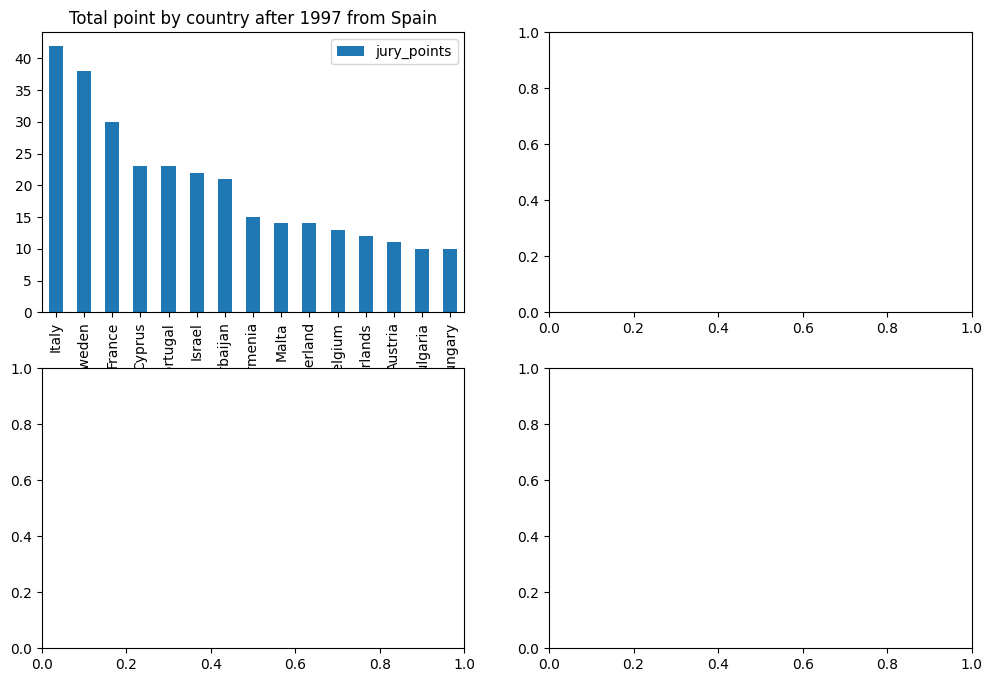

In [178]:
family_points(df_final_round, country_id='Spain', initial_year=1997, final_year=2023)

In [40]:
def plot_family_points(country_points, initial_year, final_year, countries, country_id_to_name, country_id):
    
    # Range of years
    years = np.arange(initial_year, final_year + 1)

    total_points = np.zeros(country_points.shape[1])
    for i in range(country_points.shape[1]):
        total_points[i] = country_points[:,i].sum()
    
    # Normalize the points
    total_points = total_points / total_points.sum()

    for i,c in enumerate(countries):
        countries[i] = country_id_to_name[c]
    
    country_id = country_id_to_name[country_id]
        
    # Plot the number of points given by country_id to each country
    plt.figure(figsize=(10, 6))
    plt.bar(countries, total_points)
    plt.xticks(rotation=90)
    plt.ylabel('Percentage of points')
    plt.title(f'Percentage of points given by {country_id} to each country')
    plt.show()

    return


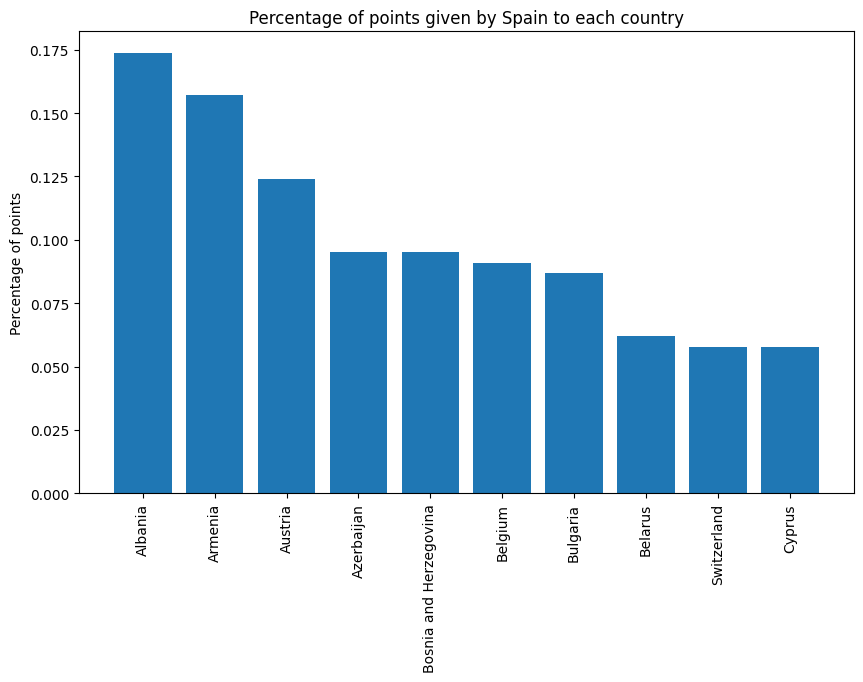

In [43]:
country_id = 'es'
country_points, countries = family_points(df_final_round, country_id, initial_year=2000, final_year=2023)

plot_family_points(country_points, initial_year, final_year, countries, country_id_to_name, country_id)

In [42]:
# mirar total points only jury